In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time
import wandb
import pytorch_lightning as pl
import sqlite3

import FunctionCollection as fc
import importlib
fc = importlib.reload(fc)
import os

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'Muon_Angle_m23b'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': True,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '2nr3',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'lr': 1e-3,
        'batch_size': 512,
        'output_offset': [3.14,1.57],
        'filename': 'dev_level7_mu_e_tau_oscweight_newfeats_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith',
        'TrTV': (0.9,0.95,1),#(0.025,0.995,1)
        'SRT_clean': False
       }

In [3]:
centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})
centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

from typing import List
@torch.jit.script
def batch_transform(x,events: List[int]):
    tmp_x = x.unsqueeze(1) - x
    cart = tmp_x[:,:,-3:]
    
    rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
    rho_mask = rho.squeeze() != 0
    if rho_mask.sum() != 0:
        cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
    tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
    return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

In [4]:
# filepath = os.path.join(path,'raw_data/dev_level7_mu_e_tau_oscweight_000/data')
filepath = os.path.join(path,'raw_data')


# tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\transformers.pkl')
# # tf = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_000\data\meta\transformers.pkl')
# event_nos = pd.read_pickle(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\datasets\event_nos_500k_muon_set1.pkl').values.reshape(-1)

# def x_transform(df):
#     pos = ['dom_x','dom_y','dom_z']
#     for col in pos:
#         df[col] = tf['features'][col].inverse_transform(df[[col]])
#     df[pos] /= 300
#     return torch.tensor(df.values)
# def y_transform(df):
#     for col in df.columns:
#         df[col] = tf['truth'][col].inverse_transform(df[[col]])
#     return torch.tensor(df.values)

# #@torch.jit.script
# def x_transform(df):
#     df['charge_log10'] = (df['charge_log10'] - charge_center)/charge_scale
#     df['dom_time'] = (df['dom_time'] - time_center)/time_scale
#     df[['dom_x','dom_y','dom_z']] /= 300
#     return torch.tensor(df.values)
# #@torch.jit.script
# def y_transform(df):
#     return torch.tensor(df.values)

# with sqlite3.connect(os.path.join(filepath,args['filename'])) as con:
#     event_nos = pd.read_sql("SELECT COUNT(*), event_no FROM features GROUP BY event_no", con)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
#                                y_transform = y_transform,
#                                batch_transform = batch_transform,
                               shuffle = True,
                               SRT_clean = args['SRT_clean'],
                              #  reweighter = ze_reweighter
                               )

In [5]:
train_loader, test_loader, val_loader = dataset.return_dataloaders(batch_size=args['batch_size'], num_workers=0) #~0.6sec loading time pr. batch

In [6]:
import Model_Loaders.Model_23 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net()

device = torch.device('cuda')

model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [7]:
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,
                                          ckpt = run_name + '_latest.ckpt',
                                          patience = 7
                                          )

C:\Users\jv97\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: Checkpoint directory C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning/checkpoints/Muon_Angle_m23b_2nr3 exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name          | Type         | Params
-----------------------------------------------
0 | act           | SiLU         | 0     
1 | scatter_norm  | scatter_norm | 70    
2 | x_encoder     | MLP          | 640   
3 | CoC_encoder   | MLP          | 2.6 K 
4 | convs         | ModuleList   | 29.1 K
5 | scatter_norms | ModuleList   | 640   
6 | decoder       | MLP          | 25.0 K
-----------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)


Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\lr_find_temp_model.ckpt


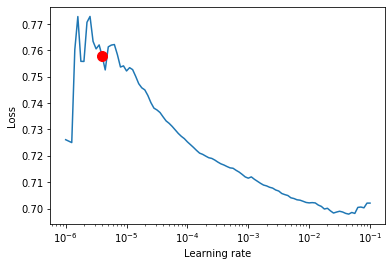

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


3.981071705534972e-06
if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [46]:
lr_finder = trainer.tuner.lr_find(model,train_loader,val_loader,min_lr=1e-6,max_lr=1e-1,num_training=100,mode='exponential',early_stop_threshold=4)

fig = lr_finder.plot(True,True)
print(lr_finder.suggestion())

args['lr'] = lr_finder.suggestion()
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

In [47]:
args['lr'] = 1e-4
Net = M.Load_model(args['type'],args)
model = Net()
trainer, wandb_logger = fc.return_trainer(path = path,
                                          run_name = run_name,
                                          args = args,)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [48]:
wandb_logger.experiment.config.update(args)
# wandb_logger.watch(model)
wandb_logger.experiment.log({f'lr finder, lr={lr_finder.suggestion()}': wandb.Image(fig)})

wandb: Currently logged in as: vinther901 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
trainer.fit(model, train_loader, val_loader)

wandb: Currently logged in as: vinther901 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name          | Type         | Params
-----------------------------------------------
0 | act           | SiLU         | 0     
1 | scatter_norm  | scatter_norm | 70    
2 | x_encoder     | MLP          | 640   
3 | CoC_encoder   | MLP          | 2.6 K 
4 | convs         | ModuleList   | 29.1 K
5 | scatter_norms | ModuleList   | 640   
6 | decoder       | MLP          | 25.0 K
-----------------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:234: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
Restored states from the checkpoint file at C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning/checkpoints/Muon_Angle_m23b_2nr3/Muon_Angle_m23b_latest.ckpt


MisconfigurationException: ModelCheckpoint(monitor='Val Acc') not found in the returned metrics: ['Train Loss', 'Train Acc']. HINT: Did you call self.log('Val Acc', tensor) in the LightningModule?

In [9]:
trainer.save_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
print("potentially remember wandb.finish()")

potentially remember wandb.finish()


C:\Users\jv97\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [26]:
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
# model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/oscnext_AngleO_m12-epoch=111-Val Acc=0.727.ckpt')
model.to(device);

In [27]:
pred, truth = fc.return_reco_truth(model,train_loader)

Batch: 100%|█████████████████████████████████| 196/196 [03:15<00:00,  1.31it/s]

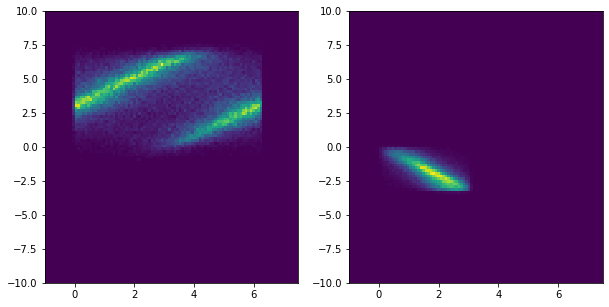

In [28]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

ax[0].hist2d(truth[:,0],pred[:,0]+3.14,bins=100,range=((-1,7.5),(-10,10)))
ax[1].hist2d(truth[:,1],pred[:,1],bins=100,range=((-1,7.5),(-10,10)));

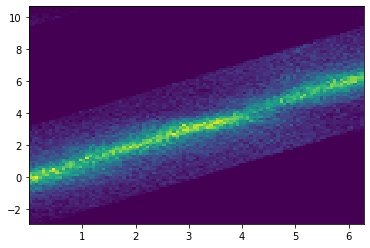

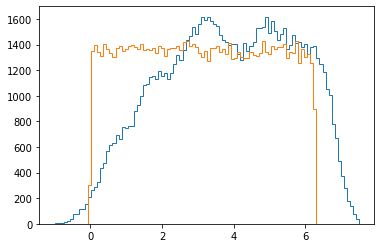

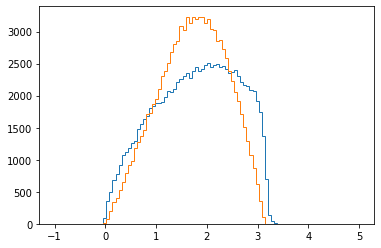

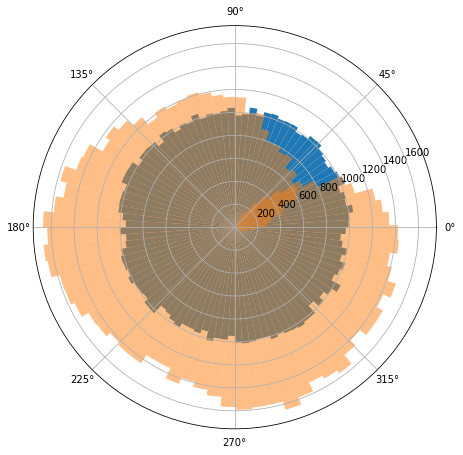

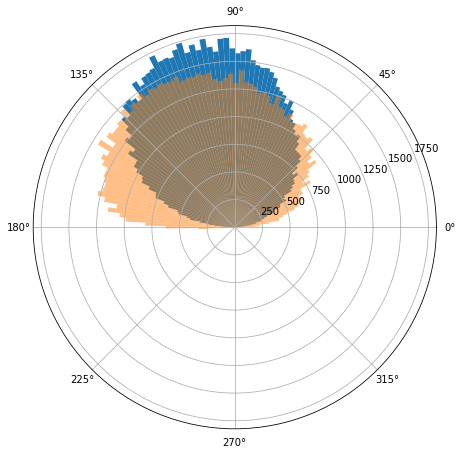

In [30]:
tmp = pred[:,0].copy()
tmp[np.abs(tmp - truth[:,0]) > np.pi] += 2*np.pi
fig, ax = plt.subplots()
ax.hist2d(truth[:,0],tmp,bins=100)#,range=((-1,7),(-1,7)));
np.quantile(abs(tmp - truth[:,0])*180/np.pi,(0,0.68))

fig, ax = plt.subplots()
ax.hist(pred[:,0]+3.14,bins=100,range=(-1,7.5),histtype='step');
ax.hist(truth[:,0],bins=100,range=(-1,7.5),histtype='step');

fig, ax = plt.subplots()
ax.hist(abs(pred[:,1]),bins=100,range=(-1,2*2.5),histtype='step');
ax.hist(truth[:,1],bins=100,range=(-1,2*2.5),histtype='step');

fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,0],bins=100);
ax.hist(pred[:,0]+3.14,bins=100,alpha=0.5);
# help(ax)

fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,1],bins=100);
ax.hist(abs(pred[:,1]),bins=100,alpha=0.5);

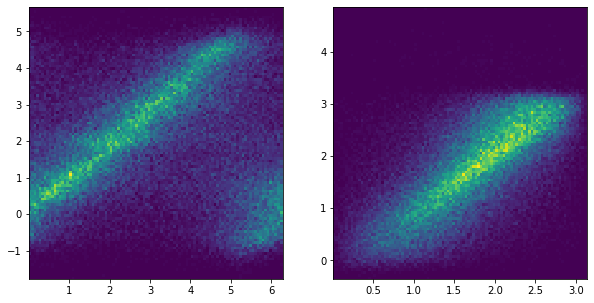

In [25]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

ax[0].hist2d(truth[:,0],pred[:,0]+3.14,bins=100)
ax[1].hist2d(truth[:,1],pred[:,1],bins=100);

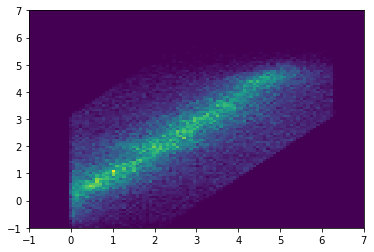

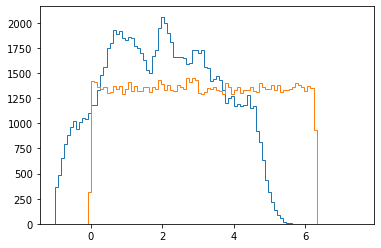

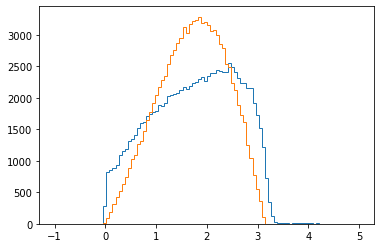

In [46]:
tmp = pred[:,0].copy() + 3.14
tmp[np.abs(tmp - truth[:,0]) > np.pi] -= 2*np.pi
fig, ax = plt.subplots()
ax.hist2d(truth[:,0],tmp,bins=100,range=((-1,7),(-1,7)));
np.quantile(abs(tmp - truth[:,0])*180/np.pi,(0,0.68))

fig, ax = plt.subplots()
ax.hist(pred[:,0]+3.14,bins=100,range=(-1,7.5),histtype='step');
ax.hist(truth[:,0],bins=100,range=(-1,7.5),histtype='step');

fig, ax = plt.subplots()
ax.hist(abs(pred[:,1]),bins=100,range=(-1,2*2.5),histtype='step');
ax.hist(truth[:,1],bins=100,range=(-1,2*2.5),histtype='step');

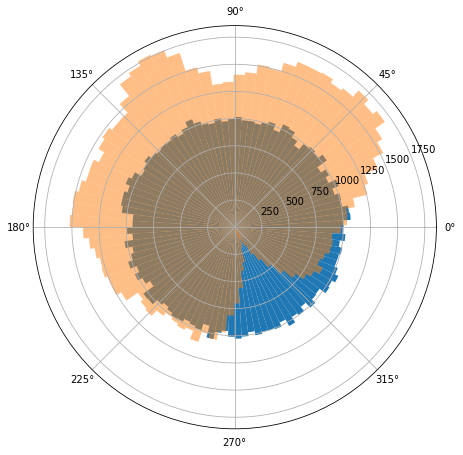

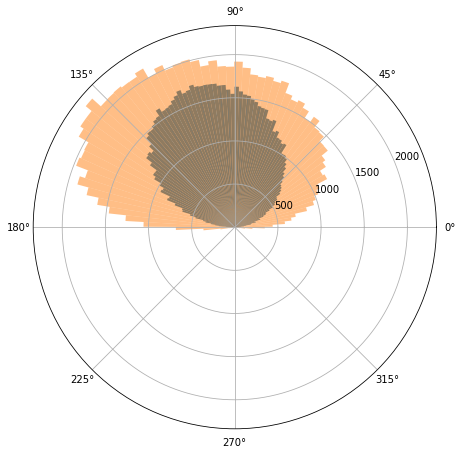

In [49]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,0],bins=100);
ax.hist(pred[:,0]+3.14,bins=100,alpha=0.5);
# help(ax)

fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],polar=True)
ax.hist(truth[:,1],bins=100);
ax.hist(pred[:,1],bins=100,alpha=0.5);

In [24]:
output, cov = model.output_post_processor(torch.tensor(pred))
y = model.y_post_processor(torch.tensor(truth))

# model.cal_acc(torch.tensor(pred[:,:2] + args['output_offset']),torch.tensor(truth))
model.crit(output,cov,y,None), model.cal_acc(output,y)

(tensor(-0.1176, dtype=torch.float64), 0.42082032561302185)

In [10]:
wandb.finish()

_runtime,22363
Train Acc,0.94071
Train Loss,0.66519
_timestamp,1620831980
_step,11781
epoch,1
lr-Adam,1e-05
trainer_step,37049


lr-Adam,▁
trainer_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,▆▆▆▇█▆▇▄▅▃▄▆▇▅▄▇▅▆▆▅▆▅▄▅▁▅▅▃▅▆▅▅▅▅▅▅▅▅▅▂
Train Acc,█▆▅▅▅▄▅▃▃▁▂▅▅▂▃▅▅▃▄▄▃▂▂▄▂▄▄▃▃▄▃▃▃▄▂▁▂▃▃▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
